In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Conv2D, AveragePooling2D, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns


In [3]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2 ,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shuffle=False,
    validation_split=0.2)

In [7]:

!pip install kaggle --quiet

!mkdir -p ~/.kaggle

from google.colab import files
uploaded = files.upload()

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d roobansappani/hand-gesture-recognition

!unzip -q hand-gesture-recognition.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/roobansappani/hand-gesture-recognition
License(s): copyright-authors
100% 27.0M/27.1M [00:02<00:00, 19.7MB/s]
100% 27.1M/27.1M [00:02<00:00, 12.0MB/s]


In [8]:
train_data = datagen.flow_from_directory(
    r'/content/HandGesture/images',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training')

val_data = datagen.flow_from_directory(
    r'/content/HandGesture/images',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation')

Found 4199 images belonging to 10 classes.
Found 1044 images belonging to 10 classes.


In [9]:
class_indices = train_data.class_indices
print(class_indices)
class_indices = train_data.class_indices
print("Class Indices:", class_indices)

class_labels = train_data.classes

{'call_me': 0, 'fingers_crossed': 1, 'okay': 2, 'paper': 3, 'peace': 4, 'rock': 5, 'rock_on': 6, 'scissor': 7, 'thumbs': 8, 'up': 9}
Class Indices: {'call_me': 0, 'fingers_crossed': 1, 'okay': 2, 'paper': 3, 'peace': 4, 'rock': 5, 'rock_on': 6, 'scissor': 7, 'thumbs': 8, 'up': 9}


In [10]:
class_counts = {class_name: np.sum(class_labels == class_index)
                for class_name, class_index in class_indices.items()}

In [11]:
print("Number of images in each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Number of images in each class:
call_me: 422 images
fingers_crossed: 404 images
okay: 432 images
paper: 432 images
peace: 421 images
rock: 407 images
rock_on: 425 images
scissor: 422 images
thumbs: 430 images
up: 404 images


In [12]:
def dense_block(input_tensor, num_layers, growth_rate):

    x = input_tensor
    for _ in range(num_layers):
        layer_output = BatchNormalization()(x)
        layer_output = tf.keras.layers.ReLU()(layer_output)
        layer_output = Conv2D(growth_rate, (3, 3), padding='same')(layer_output)
        x = concatenate([x, layer_output])
    return x


In [13]:
def dense_block(input_tensor, num_layers, growth_rate):
    """
    Creates a Dense Block.
    Args:
        input_tensor: Input tensor to the dense block.
        num_layers: Number of layers in the block.
        growth_rate: Number of filters to add per layer (growth rate).
    Returns:
        Output tensor of the dense block.
    """
    x = input_tensor
    for _ in range(num_layers):
        layer_output = BatchNormalization()(x)
        layer_output = tf.keras.layers.ReLU()(layer_output)
        layer_output = Conv2D(growth_rate, (3, 3), padding='same')(layer_output)
        x = concatenate([x, layer_output])  # Concatenate input with output
    return x
def transition_layer(input_tensor, compression_factor=0.5):
    """
    Creates a Transition Layer.
    Args:
        input_tensor: Input tensor to the transition layer.
        compression_factor: Factor to reduce the number of feature maps.
    Returns:
        Output tensor of the transition layer.
    """
    num_filters = int(input_tensor.shape[-1] * compression_factor)
    x = BatchNormalization()(input_tensor)
    x = tf.keras.layers.ReLU()(x)
    x = Conv2D(num_filters, (1, 1), padding='same')(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x


In [14]:

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

In [15]:


x = base_model.output


x = dense_block(x, num_layers=2, growth_rate=4)
x = transition_layer(x, compression_factor=0.5)
x = dense_block(x, num_layers=2, growth_rate=4)


x = GlobalAveragePooling2D()(x)
x = Dense(len(class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)




In [17]:


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)


val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,703,446 (29.39 MB)

 Trainable params: 657,702 (2.51 MB)

 Non-trainable params: 7,045,744 (26.88 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6818 - loss: 0.9911 - val_accuracy: 0.9301 - val_loss: 0.2164
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 915ms/step - accuracy: 0.9452 - loss: 0.1696 - val_accuracy: 0.9521 - val_loss: 0.1560
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 947ms/step - accuracy: 0.9720 - loss: 0.0958 - val_accuracy: 0.9502 - val_loss: 0.1459
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 923ms/step - accuracy: 0.9701 - loss: 0.0974 - val_accuracy: 0.9607 - val_loss: 0.1312
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 942ms/step - accuracy: 0.9714 - loss: 0.0947 - val_accuracy: 0.9416 - val_loss: 0.1833
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 911ms/step - accuracy: 0.9700 - loss: 0.0833 - val_accuracy: 0.9607 - val_loss: 0.1104
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 939ms/step - accuracy: 0.9760 - loss: 0.0647 - val_accuracy: 0.9416 - val_loss: 0.1554
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 953ms/step - accuracy: 0.9751 - loss: 0.0730 - val_accuracy: 0.9588 

In [18]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2,
    verbose=1)


Epoch 1/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.8592 - loss: 0.4667 - val_accuracy: 0.9253 - val_loss: 0.2320
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9828 - loss: 0.0572 - val_accuracy: 0.9521 - val_loss: 0.1828


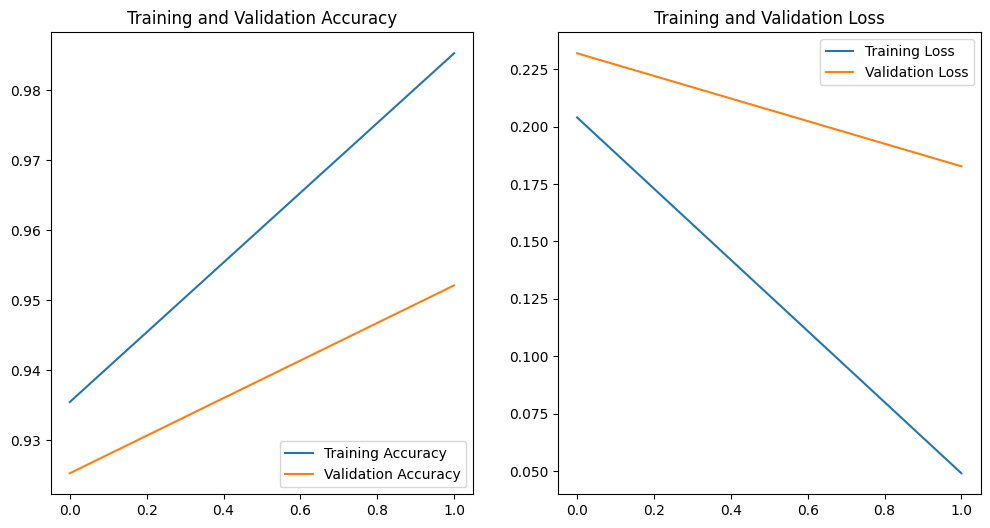

In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history_fine_tune)

17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 802ms/step


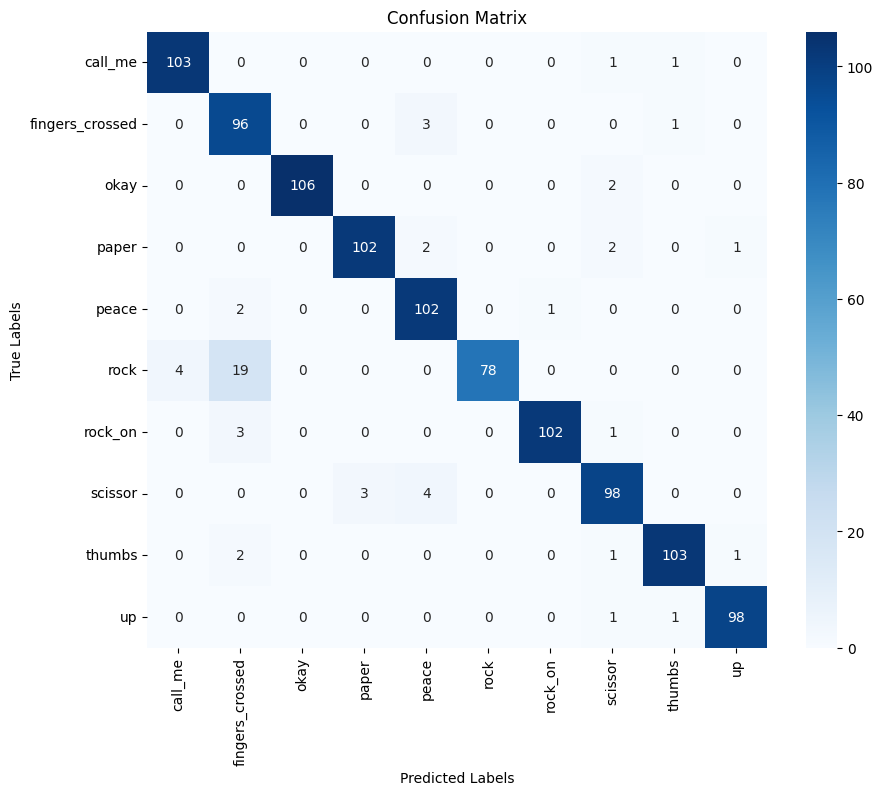

In [23]:
y_true = np.concatenate([val_data[i][1] for i in range(len(val_data))])
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(model.predict(val_data), axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [24]:
print("True Labels:", y_true[:10])
print("Predicted Labels:", y_pred[:10])
print("Class Indices:", val_data.class_indices)


True Labels: [3 9 3 9 0 3 8 7 6 6]
Predicted Labels: [3 9 3 9 0 3 8 7 6 6]
Class Indices: {'call_me': 0, 'fingers_crossed': 1, 'okay': 2, 'paper': 3, 'peace': 4, 'rock': 5, 'rock_on': 6, 'scissor': 7, 'thumbs': 8, 'up': 9}


In [1]:
class_report = classification_report(y_true, y_pred, target_names=val_data.class_indices.keys())
print("Classification Report:\n", class_report)


NameError: name 'classification_report' is not defined

In [ ]:
y_true = val_data.classes
n_classes = len(val_data.class_indices)


y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

y_pred_prob = model.predict(val_data)


print("y_true_one_hot shape:", y_true_one_hot.shape)
print("y_pred_prob shape:", y_pred_prob.shape)

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()